/var/folders/00/t_t93b0n0wx8m9fcms_xg6640000gn/T/ipykernel_60081/635175067.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_economie = pd.read_sql(query_economie, conn)
/var/folders/00/t_t93b0n0wx8m9fcms_xg6640000gn/T/ipykernel_60081/635175067.py:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_election = pd.read_sql(query_election, conn)
/var/folders/00/t_t93b0n0wx8m9fcms_xg6640000gn/T/ipykernel_60081/635175067.py:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

Score de silhouette pour les clusters: 0.6850856419675239
Cluster 1 - Caractéristiques moyennes: [1163.06188012    6.89851229    7.26736093    8.52154161    8.94705261
    8.87412247    8.94985123    8.53460759    7.89560155    7.63427124
    7.75897154    8.54704183    9.40095084    9.96479733    9.29572229
    9.77183484    9.88547434    9.43159767    9.15054981    7.79834843
    7.09562958    7.19241483    7.73732643    8.1080207     8.20111902
    8.25693187    7.47384002    6.96081716    8.74820397    8.83898663
    8.72852307    9.35850798    9.89729409    9.84995472    9.98374946
    9.69109314    9.00479948    8.57810263    8.05455153    7.68807891
    7.42597025    6.86812635    6.83801854]
Cluster 2 - Caractéristiques moyennes: [1.071357e+06 6.550000e+00 6.850000e+00 7.520000e+00 8.070000e+00
 8.480000e+00 8.600000e+00 8.800000e+00 8.480000e+00 8.850000e+00
 9.570000e+00 9.720000e+00 1.005000e+01 1.007000e+01 9.650000e+00
 1.002000e+01 9.980000e+00 9.800000e+00 9.450000e+00 8

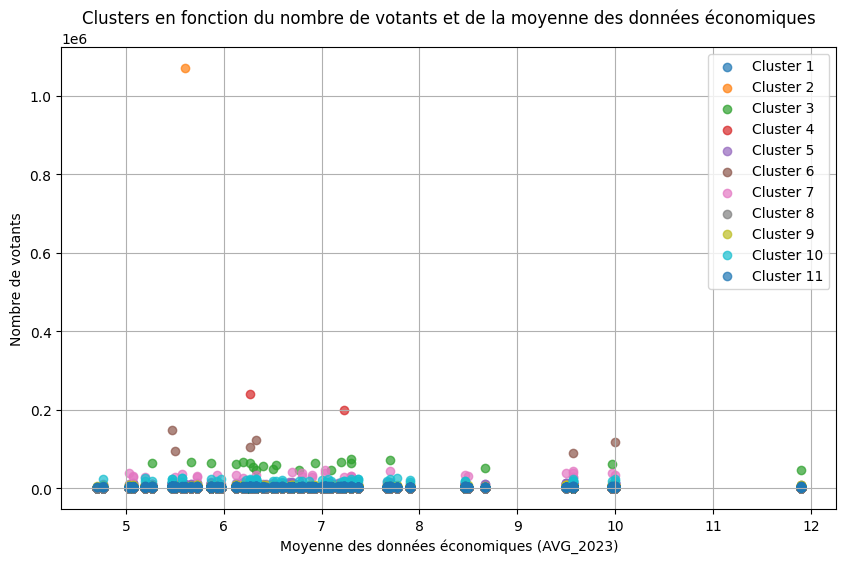

In [2]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score

# Dictionnaire de correspondance entre les noms des partis politiques et leurs identifiants numériques
id_to_party_dict = {
    1: "Lutte Ouvrière",
    2: "Parti Communiste Français",
    3: "La République En Marche",
    4: "Résistons",
    5: "Rassemblement National",
    6: "Reconquête",
    7: "La France Insoumise",
    8: "Parti Socialiste",
    9: "Europe Écologie Les Verts",
    10: "Les Républicains",
    11: "Nouveau Parti Anticapitaliste",
    12: "Debout La France"
}

# Paramètres de connexion à la base de données PostgreSQL
conn_params = {
    "host": "localhost",
    "port": "15432", 
    "database": "postgres",
    "user": "admin",
    "password": "admin"
}

# Connexion à la base de données
conn = psycopg2.connect(**conn_params)

# Requête SQL pour récupérer les données de la table economie
query_economie = """
    SELECT avg_1982, avg_1983, avg_1984, avg_1985, avg_1986, avg_1987, avg_1988, avg_1989, avg_1990,
           avg_1991, avg_1992, avg_1993, avg_1994, avg_1995, avg_1996, avg_1997, avg_1998, avg_1999,
           avg_2000, avg_2001, avg_2002, avg_2003, avg_2004, avg_2005, avg_2006, avg_2007, avg_2008,
           avg_2009, avg_2010, avg_2011, avg_2012, avg_2013, avg_2014, avg_2015, avg_2016, avg_2017,
           avg_2018, avg_2019, avg_2020, avg_2021, avg_2022, avg_2023, code_postal
    FROM economie
"""
df_economie = pd.read_sql(query_economie, conn)

# Requête SQL pour récupérer les données de la table electiont1
query_election = """
    SELECT winner, code_postal, "Libellé de la commune", "Votants"
    FROM election_2022_t1
"""
df_election = pd.read_sql(query_election, conn)
# Fermeture de la connexion
conn.close()

# Mapper les noms des partis politiques aux identifiants numériques
party_to_id_dict = {v: k for k, v in id_to_party_dict.items()}
df_election["winner"] = df_election["winner"].map(party_to_id_dict)

# Remplacer les valeurs manquantes dans la colonne "winner" par une valeur arbitraire
df_election["winner"].fillna(-1, inplace=True)

# Convertir la colonne "winner" en float
df_election["winner"] = df_election["winner"].astype(float)

# Encodage des variables catégorielles
label_encoder = LabelEncoder()

# Exclure les données du département de l'Yonne (89) du jeu d'entraînement
df_train = df_election[df_election["code_postal"] != 89]

# Sélectionner uniquement les données du département de l'Yonne (89) pour les tests
df_test_yonne = df_election[df_election["code_postal"] == 89]

# Ajouter 10 autres départements au département de l'Yonne (89) pour les tests
other_departments = [90, 91, 92, 93, 94, 95, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for department in other_departments:
    df_test_yonne = pd.concat([df_test_yonne, df_election[df_election["code_postal"] == department]])

# Exclure les données des départements ajoutés des données d'entraînement
df_train = df_train[~df_train["code_postal"].isin(other_departments)]

# Fusionner les données économiques avec les données d'entraînement
df_train = pd.merge(df_train, df_economie, on="code_postal", how="inner")

# Sélection des colonnes à utiliser pour le clustering
X_train = df_train.drop(columns=["Libellé de la commune", "winner", "code_postal"])

# Entraînement du modèle de clustering K-means avec 11 clusters
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans.fit(X_train)

# Ajout des clusters prédits au DataFrame combiné
df_train["cluster"] = kmeans.labels_

# Évaluation de la silhouette pour déterminer la cohésion des clusters
silhouette_avg = silhouette_score(X_train, kmeans.labels_)
print("Score de silhouette pour les clusters:", silhouette_avg)

# Affichage des caractéristiques de chaque cluster
cluster_centers = kmeans.cluster_centers_
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i + 1} - Caractéristiques moyennes:", center)

# Visualisation des clusters en fonction des caractéristiques moyennes
plt.figure(figsize=(10, 6))
for cluster in range(11):
    cluster_data = df_train[df_train["cluster"] == cluster]
    plt.scatter(cluster_data["avg_2023"], cluster_data["Votants"], label=f"Cluster {cluster + 1}", alpha=0.7)

plt.xlabel("Moyenne des données économiques (AVG_2023)")
plt.ylabel("Nombre de votants")
plt.title("Clusters en fonction du nombre de votants et de la moyenne des données économiques")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
@